In [1]:
import numpy
from sklearn.metrics import accuracy_score
import tensorflow as tf
import matplotlib.pyplot as plt

from tslearn.datasets import CachedDatasets
from tslearn.preprocessing import TimeSeriesScalerMinMax
from tslearn.shapelets import LearningShapelets, \
    grabocka_params_to_shapelet_size_dict
from tslearn.utils import ts_size
import numpy
from sklearn.metrics import accuracy_score

from tslearn.generators import random_walk_blobs
from tslearn.preprocessing import TimeSeriesScalerMinMax, \
    TimeSeriesScalerMeanVariance
from tslearn.neighbors import KNeighborsTimeSeriesClassifier, \
    KNeighborsTimeSeries
import pandas as pd
import numpy as np
import random
from tslearn.datasets import UCR_UEA_datasets
from tslearn.preprocessing import TimeSeriesResampler

In [72]:
df = pd.read_pickle("Train.pkl")
randomlist1 = random.sample(range(0, 260), 78)

df_test1 = df.loc[df["Batch"].isin(randomlist1)]
df_train1 = df.loc[~df["Batch"].isin(randomlist1)]
df_steps1 = df_test1.loc[df_test1["CuStepNo ValueY"] != df_test1["Next_Step"]]
df_steps2 = df_train1.loc[df_train1["CuStepNo ValueY"] != df_train1["Next_Step"]]


In [73]:
y_train1 = df_steps2.loc[df_steps2["CuStepNo ValueY"] == 7,"DeviationID ValueY"].astype(int)
y_test1 = df_steps1.loc[df_steps1["CuStepNo ValueY"] == 7,"DeviationID ValueY"].astype(int)
X_train1 = df_train1.drop(["DeviationID ValueY","Next_Step","timestamp","Unnamed: 0"],axis=1)
X_test1 = df_test1.drop(["DeviationID ValueY","Next_Step","timestamp","Unnamed: 0"],axis=1)

In [74]:
X_train_step1 = []
for i in X_train1.Batch.unique():
        num = numpy.array(X_train1.loc[(X_train1["Batch"] == i)&(X_train1["CuStepNo ValueY"] == 7)].drop(["Batch","CuStepNo ValueY"],axis=1))
        X_train_step1.append(num)

In [76]:
X_test_step1 = []
for i in X_test1.Batch.unique():
        num = numpy.array(X_test1.loc[(X_test1["Batch"] == i)&(X_test1["CuStepNo ValueY"] == 7)].drop(["Batch","CuStepNo ValueY"],axis=1))
        X_test_step1.append(num)

In [77]:
length = []
for i in X_train_step1:
    length.append(len(i))

In [78]:
X_train_s1 = TimeSeriesResampler(sz=int(np.median(length))).fit_transform(X_train_step1)
X_test_s1 = TimeSeriesResampler(sz=int(np.median(length))).fit_transform(X_test_step1)

In [18]:
# X_train_s1 = X_train_s1.reshape(X_train_s1.shape[0],39,X_train_s1.shape[1])
# X_test_s1 = X_test_s1.reshape(X_test_s1.shape[0],39,X_test_s1.shape[1])

In [79]:
scaler = TimeSeriesScalerMinMax()
X_train = scaler.fit_transform(X_train_s1)
X_test = scaler.transform(X_test_s1)

In [9]:
n_ts, ts_sz = X_train_s1.shape[:2]
n_classes = len(set(y_train1))

In [61]:
X_train_s1.shape

(175, 72, 39)

In [11]:
shapelet_sizes = grabocka_params_to_shapelet_size_dict(n_ts=n_ts,
                                                       ts_sz=ts_sz,
                                                       n_classes=n_classes,
                                                       l=0.1,
                                                       r=1)

In [60]:
y_test1.shape

(76,)

In [ ]:
{7:10}

In [80]:
shp_clf = LearningShapelets(n_shapelets_per_size={7:10},
                            optimizer=tf.optimizers.Adam(.01),
                            batch_size=200,
                            weight_regularizer=.01,
                            max_iter=250,
                            random_state=42,
                            scale=True,
                            verbose=0)
shp_clf.fit(X_train, y_train1)

LearningShapelets(batch_size=200, max_iter=250, n_shapelets_per_size={7: 10},
                  optimizer=<keras.optimizers.adam.Adam object at 0x000001DF0AE00C40>,
                  random_state=42, scale=True, weight_regularizer=0.01)

In [81]:
pred_labels = shp_clf.predict(X_test)
print("Correct classification rate:", accuracy_score(y_test1, pred_labels))

Correct classification rate: 0.6666666666666666


In [21]:
from sklearn import preprocessing

In [86]:
X_train2 = shp_clf.transform(X_train)

In [87]:
scaler = preprocessing.StandardScaler().fit(X_train2)
X_train2 = scaler.transform(X_train2)
X_test2 = shp_clf.transform(X_test)
X_test2 = scaler.transform(X_test2)

In [88]:
#import from sklearn logistic regression
from sklearn.linear_model import LogisticRegression
#instantiate the model (using the default parameters)
logreg = LogisticRegression(max_iter=1000)
#fit the model with data
logreg.fit(X_train2,y_train1)



LogisticRegression(max_iter=1000)

In [89]:


y_pred=logreg.predict(X_test2)

#accuracy
from sklearn import metrics
print("Accuracy:",metrics.accuracy_score(y_test1, y_pred))

Accuracy: 0.6794871794871795


In [24]:
shapelets = shp_clf.shapelets_as_time_series_


In [32]:
shapelets.shape

(10, 7, 39)

In [29]:
distances.__len__()

2535

In [31]:
predicted_locations.shape

(174, 10)

In [14]:
distances = shp_clf.transform(X_train)
predicted_locations = shp_clf.locate(X_train)

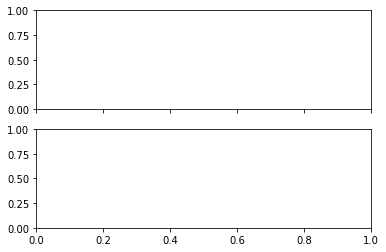

In [20]:
f, ax = plt.subplots(2, 1, sharex=True)

In [39]:
shp_clf.shapelets_[0]

array([[-4.50894624e-01,  7.17839718e-01, -4.84901816e-01,
        -8.07741210e-02, -1.07031308e-01, -7.86664411e-02,
         1.54845321e+00,  8.57971549e-01,  8.75281394e-02,
         2.06493437e-01, -3.39429267e-03,  7.92063549e-02,
         1.20151289e-01,  1.34139806e-01,  2.73010045e-01,
         1.27294645e-01,  1.89214461e-02,  9.18655574e-01,
         3.05592924e-01, -1.81687266e-01, -2.80300379e-02,
        -2.60364354e-01,  5.30678451e-01,  3.13649029e-01,
         2.24642232e-02, -4.80656534e-01, -6.81320488e-01,
         1.67989910e-01,  5.18641114e-01,  4.94013093e-02,
        -1.10039926e+00,  9.03838221e-03,  8.69239569e-01,
         8.39002848e-01,  7.23928452e-01,  1.04000759e+00,
        -8.28934729e-01,  3.75691913e-02,  4.41456646e-01],
       [-3.42571557e-01,  9.24383342e-01, -9.20294762e-01,
         2.10912183e-01, -2.51526266e-01, -2.05024496e-01,
         2.26123005e-01,  8.33719015e-01, -1.06468648e-01,
         3.74998618e-03, -7.05182040e-03,  8.92253965e-

Für des erste Shapelet

In [132]:
scaler._X_fit_dims

(174, 72, 39)

In [11]:
#list in range from 1 to 7
list1 = []
for i in range(1,8):
    list1.append(i)

In [12]:
list1

[1, 2, 3, 4, 5, 6, 7]

In [225]:
scaler2 = TimeSeriesScalerMinMax()

In [15]:
shp_clf.shapelets_as_time_series_.shape

(10, 7, 39)

In [34]:
int(y_train1[0:1])

7

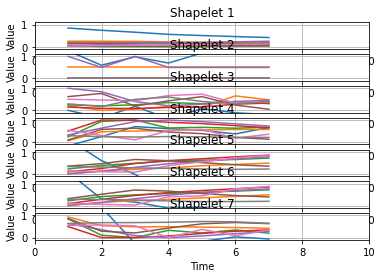

In [57]:
#make subplots
f, ax = plt.subplots(7, 1, sharey="col")
#loop through the shapelets
for i in range(0,7):
    #loop through the classes
    ax[i].plot(list1,shp_clf.shapelets_as_time_series_[0][:,i])
    for j in range(0,7):
        #get the index of the shapelet
        index = np.where(y_train1 == list1[j])
        #get the shapelet
        shapelet = shp_clf.shapelets_as_time_series_[i]
        #plot the shapelet
        ax[i].plot(list1, X_train[j][shp_clf.locate(X_train)[j][0]:shp_clf.locate(X_train)[j][0]+7][:,i])
        ax[i].set_title("Shapelet " + str(i+1))
        ax[i].set_ylabel("Value")
        ax[i].set_xlabel("Time")
        ax[i].set_xlim(0,10)
        ax[i].set_ylim(-0.1,1.1)
        ax[i].grid(True)

plt.show()


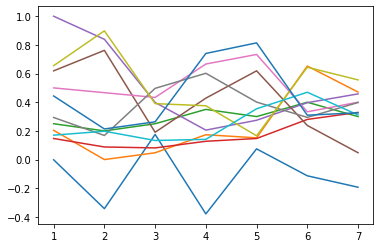

In [45]:

plt.plot(list1,shp_clf.shapelets_as_time_series_[0][:,2])
for i in range(0,10):
    plt.plot(list1, X_train[i][shp_clf.locate(X_train)[i][0]:shp_clf.locate(X_train)[i][0]+7][:,2],
)


ValueError: 1 is not a valid value for color

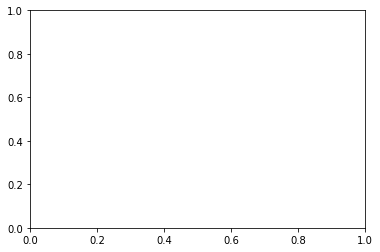

In [43]:
plt.plot(list1,shp_clf.shapelets_as_time_series_[0][:,2],color=1)

In [38]:
from plotly.subplots import make_subplots
import plotly.graph_objects as go

fig = make_subplots(rows=1, cols=2)

In [53]:
shp_clf.locate(X_train)[0]

array([ 0,  2,  0, 32, 64,  4, 19, 45, 34, 24])

In [48]:
X_train[i]

array([[0.00882749, 0.33333333, 0.68484009, ..., 0.5       , 0.        ,
        0.42070467],
       [0.00529455, 0.33333333, 0.5591485 , ..., 0.5       , 0.        ,
        0.19577232],
       [0.00244039, 0.33333333, 0.93992006, ..., 0.5       , 0.        ,
        0.        ],
       ...,
       [0.99108726, 0.66666667, 0.81422867, ..., 1.        , 0.        ,
        0.4609462 ],
       [1.        , 0.33333333, 0.75138935, ..., 0.5       , 0.        ,
        0.5262546 ],
       [0.99389208, 0.33333333, 0.81607688, ..., 0.5       , 0.        ,
        0.68865435]])

In [46]:
X_train[i][shp_clf.locate(X_train)[i][0]:shp_clf.locate(X_train)[i][0]+7][:,2]

array([0.44362763, 0.21349113, 0.26340361, 0.74029225, 0.81422695,
       0.30960861, 0.3262494 ])

In [55]:
import plotly.express as px
import plotly.graph_objects as go

# px.line(x=list1,y=shp_clf.shapelets_as_time_series_[0][:,0])
# px.line(x=list1,y=X_train[0][8:15][:,0])
#combine both plotly plots
fig = go.Figure()
fig.add_trace(go.Scatter(x=list1, y=shp_clf.shapelets_as_time_series_[0][:,2],
                    mode='lines',
                    name='Deviation1'))
for i in range(0,10):
    fig.add_trace(go.Scatter(x=list1, y=X_train[i][shp_clf.locate(X_train)[i][0]:shp_clf.locate(X_train)[i][0]+7][:,2],
                        mode='lines',
                        name=f'Time Series {int(y_train1[i:i+1])}'))
fig.update_layout(title='Shapelet nr. 1',
                     xaxis_title='Time',
                        yaxis_title='Value')

In [137]:
import plotly.express as px
import plotly.graph_objects as go

# px.line(x=list1,y=shp_clf.shapelets_as_time_series_[0][:,0])
# px.line(x=list1,y=X_train[0][8:15][:,0])
#combine both plotly plots
fig = go.Figure()
fig.add_trace(go.Scatter(x=list1, y=scaler.fit_transform(shp_clf.shapelets_as_time_series_[0]).reshape(7,39)[:,0],
                    mode='lines',
                    name='Shapelet'))
for i in range(0,7):
    fig.add_trace(go.Scatter(x=list1, y=X_train[i][shp_clf.locate(X_train)[i][0]:shp_clf.locate(X_train)[i][0]+7][:,0],
                        mode='lines',
                        name='Time Series'))
# fig.add_trace(go.Scatter(x=list1, y=X_train[0][8:15][:,0],
#                     mode='lines',
#                     name='Time Series1'))
# fig.add_trace(go.Scatter(x=list1, y=X_train[1][shp_clf.locate(X_train)[1][0]:shp_clf.locate(X_train)[1][0]+7][:,0],
#                     mode='lines',
#                     name='Time Serie2'))
#title
fig.update_layout(title='Shapelet nr. 1',
                     xaxis_title='Time',
                        yaxis_title='Value')
fig.show()

In [102]:
import plotly.express as px
import plotly.graph_objects as go

# px.line(x=list1,y=shp_clf.shapelets_as_time_series_[0][:,0])
# px.line(x=list1,y=X_train[0][8:15][:,0])
#combine both plotly plots
fig = go.Figure()
fig.add_trace(go.Scatter(x=list1, y=scaler.fit_transform(shp_clf.shapelets_as_time_series_[0]).reshape(7,39)[:,0],
                    mode='lines',
                    name='Shapelet'))
fig.add_trace(go.Scatter(x=list1, y=X_train[0][8:15][:,0],
                    mode='lines',
                    name='Time Series'))
fig.add_trace(go.Scatter(x=list1, y=X_train[0][8:15][:,0],
                    mode='lines',
                    name='Time Series'))
fig.show()

In [89]:
import plotly.express as px

px.line(x=list1,y=X_train[0][8:15][:,0])

In [17]:
shap = shp_clf.shapelets_[0]

In [21]:
test_ts_id = numpy.argmin(numpy.sum(distances, axis=1))
shap = shp_clf.shapelets_[0]
shap = TimeSeriesScalerMinMax().fit_transform(shap.reshape(1, -1, 1)).flatten()
pos = predicted_locations[test_ts_id, 0]
ax[0].plot(X_train[test_ts_id].ravel())
ax[0].plot(numpy.arange(pos, pos + len(shap)), shap, linewidth=2)
ax[0].axvline(pos, color='k', linestyle='--', alpha=0.25)
ax[0].set_title("The aligned extracted shapelet")

Text(0.5, 1.0, 'The aligned extracted shapelet')

In [22]:
distances = []
time_series = X_train[test_ts_id].ravel()
for i in range(len(time_series) - len(shap)):
    distances.append(numpy.linalg.norm(time_series[i:i+len(shap)] - shap))
ax[1].plot(distances)
ax[1].axvline(numpy.argmin(distances), color='k', linestyle='--', alpha=0.25)
ax[1].set_title('The distances between the time series and the shapelet')

plt.tight_layout()
plt.show()

<Figure size 432x288 with 0 Axes>

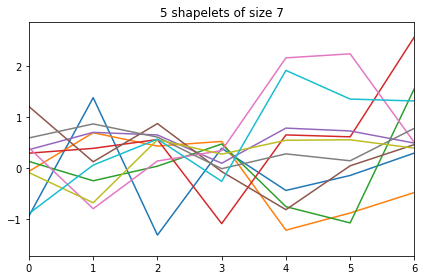

In [36]:
plt.figure()
for i, sz in enumerate(shapelet_sizes.keys()):
    plt.subplot(len(shapelet_sizes), 1, i + 1)
    plt.title("%d shapelets of size %d" % (shapelet_sizes[sz], sz))
    for shp in shp_clf.shapelets_:
        if ts_size(shp) == sz:
            plt.plot(shp.ravel())
    plt.xlim([0, max(shapelet_sizes.keys()) - 1])

plt.tight_layout()
plt.show()


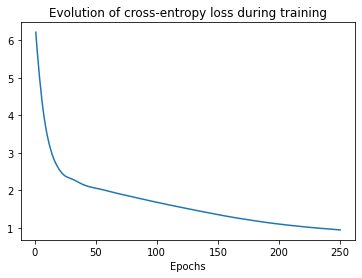

In [32]:
plt.figure()
plt.plot(numpy.arange(1, shp_clf.n_iter_ + 1), shp_clf.history_["loss"])
plt.title("Evolution of cross-entropy loss during training")
plt.xlabel("Epochs")
plt.show()

In [ ]:
y_train1 = df_steps2.loc[df_steps2["CuStepNo ValueY"] == 1,"DeviationID ValueY"].astype(int)
y_test1 = df_steps1.loc[df_steps1["CuStepNo ValueY"] == 1,"DeviationID ValueY"].astype(int)
X_train1 = df_train1.drop(["DeviationID ValueY","Next_Step","timestamp","Unnamed: 0"],axis=1)
X_test1 = df_test1.drop(["DeviationID ValueY","Next_Step","timestamp","Unnamed: 0"],axis=1)

In [39]:
X_train_step1 = []
for i in X_train1.Batch.unique():
        num = numpy.array(X_train1.loc[(X_train1["Batch"] == i)&(X_train1["CuStepNo ValueY"] == 1)].drop(["Batch","CuStepNo ValueY"],axis=1))
        X_train_step1.append(num)
X_test_step1 = []
for i in X_test1.Batch.unique():
        num = numpy.array(X_test1.loc[(X_test1["Batch"] == i)&(X_test1["CuStepNo ValueY"] == 1)].drop(["Batch","CuStepNo ValueY"],axis=1))
        X_test_step1.append(num)

In [40]:
length = []
for i in X_train_step1:
    length.append(len(i))
X_train_s1 = TimeSeriesResampler(sz=int(np.median(length))).fit_transform(X_train_step1)
X_test_s1 = TimeSeriesResampler(sz=int(np.median(length))).fit_transform(X_test_step1)

In [41]:
scaler = TimeSeriesScalerMinMax()
X_train = scaler.fit_transform(X_train_s1)
X_test = scaler.transform(X_test_s1)

In [42]:
shp_clf = LearningShapelets(n_shapelets_per_size={25:10},
                            optimizer=tf.optimizers.Adam(.01),
                            batch_size=200,
                            weight_regularizer=.01,
                            max_iter=250,
                            random_state=42,
                            scale=True,
                            verbose=0)
shp_clf.fit(X_train, y_train1)

LearningShapelets(batch_size=200, max_iter=250, n_shapelets_per_size={25: 10},
                  optimizer=<keras.optimizers.adam.Adam object at 0x000002353EA6CF70>,
                  random_state=42, scale=True, weight_regularizer=0.01)

In [43]:
pred_labels = shp_clf.predict(X_test)
print("Correct classification rate:", accuracy_score(y_test1, pred_labels))

Correct classification rate: 0.5866666666666667


In [44]:
y_train1 = df_steps2.loc[df_steps2["CuStepNo ValueY"] == 8,"DeviationID ValueY"].astype(int)
y_test1 = df_steps1.loc[df_steps1["CuStepNo ValueY"] == 8,"DeviationID ValueY"].astype(int)
X_train1 = df_train1.drop(["DeviationID ValueY","Next_Step","timestamp","Unnamed: 0"],axis=1)
X_test1 = df_test1.drop(["DeviationID ValueY","Next_Step","timestamp","Unnamed: 0"],axis=1)

In [45]:
X_train_step1 = []
for i in X_train1.Batch.unique():
        num = numpy.array(X_train1.loc[(X_train1["Batch"] == i)&(X_train1["CuStepNo ValueY"] == 8)].drop(["Batch","CuStepNo ValueY"],axis=1))
        X_train_step1.append(num)
X_test_step1 = []
for i in X_test1.Batch.unique():
        num = numpy.array(X_test1.loc[(X_test1["Batch"] == i)&(X_test1["CuStepNo ValueY"] == 8)].drop(["Batch","CuStepNo ValueY"],axis=1))
        X_test_step1.append(num)

In [46]:
length = []
for i in X_train_step1:
    length.append(len(i))
X_train_s1 = TimeSeriesResampler(sz=int(np.median(length))).fit_transform(X_train_step1)
X_test_s1 = TimeSeriesResampler(sz=int(np.median(length))).fit_transform(X_test_step1)

In [47]:
scaler = TimeSeriesScalerMinMax()
X_train = scaler.fit_transform(X_train_s1)
X_test = scaler.transform(X_test_s1)

In [48]:
X_train.shape

(176, 530, 39)

In [49]:
shp_clf = LearningShapelets(n_shapelets_per_size={50:10},
                            optimizer=tf.optimizers.Adam(.01),
                            batch_size=20,
                            weight_regularizer=.01,
                            max_iter=250,
                            random_state=42,
                            scale=True,
                            verbose=0)
shp_clf.fit(X_train, y_train1)

LearningShapelets(batch_size=20, max_iter=250, n_shapelets_per_size={50: 10},
                  optimizer=<keras.optimizers.adam.Adam object at 0x000002356ED2EC20>,
                  random_state=42, scale=True, weight_regularizer=0.01)

In [50]:
pred_labels = shp_clf.predict(X_test)
print("Correct classification rate:", accuracy_score(y_test1, pred_labels))

Correct classification rate: 0.6


In [51]:
y_train1 = df_steps2.loc[df_steps2["CuStepNo ValueY"] == 3,"DeviationID ValueY"].astype(int)
y_test1 = df_steps1.loc[df_steps1["CuStepNo ValueY"] == 3,"DeviationID ValueY"].astype(int)
X_train1 = df_train1.drop(["DeviationID ValueY","Next_Step","timestamp","Unnamed: 0"],axis=1)
X_test1 = df_test1.drop(["DeviationID ValueY","Next_Step","timestamp","Unnamed: 0"],axis=1)

In [52]:
X_train_step1 = []
for i in X_train1.Batch.unique():
        num = numpy.array(X_train1.loc[(X_train1["Batch"] == i)&(X_train1["CuStepNo ValueY"] == 3)].drop(["Batch","CuStepNo ValueY"],axis=1))
        X_train_step1.append(num)
X_test_step1 = []
for i in X_test1.Batch.unique():
        num = numpy.array(X_test1.loc[(X_test1["Batch"] == i)&(X_test1["CuStepNo ValueY"] == 3)].drop(["Batch","CuStepNo ValueY"],axis=1))
        X_test_step1.append(num)

In [53]:
length = []
for i in X_train_step1:
    length.append(len(i))
X_train_s1 = TimeSeriesResampler(sz=int(np.median(length))).fit_transform(X_train_step1)
X_test_s1 = TimeSeriesResampler(sz=int(np.median(length))).fit_transform(X_test_step1)

In [54]:
scaler = TimeSeriesScalerMinMax()
X_train = scaler.fit_transform(X_train_s1)
X_test = scaler.transform(X_test_s1)

In [55]:
X_train.shape

(176, 197, 39)

In [56]:
shp_clf = LearningShapelets(n_shapelets_per_size={20:10},
                            optimizer=tf.optimizers.Adam(.01),
                            batch_size=20,
                            weight_regularizer=.01,
                            max_iter=250,
                            random_state=42,
                            scale=True,
                            verbose=0)
shp_clf.fit(X_train, y_train1)

LearningShapelets(batch_size=20, max_iter=250, n_shapelets_per_size={20: 10},
                  optimizer=<keras.optimizers.adam.Adam object at 0x000002350C0321A0>,
                  random_state=42, scale=True, weight_regularizer=0.01)

In [57]:
pred_labels = shp_clf.predict(X_test)
print("Correct classification rate:", accuracy_score(y_test1, pred_labels))

Correct classification rate: 0.6666666666666666
